# Instalando e Carregando Pacotes

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.8.8


https://pypi.org

https://pypi.org/project/imdb-sqlite

In [6]:
# Instala o pacote
!pip install -q imdb-sqlite

Agora executamos o pacote para download dos datasets

In [7]:
# Instalar o pacote
# https://pypi.org/project/pycountry/
!pip install -q pycountry

In [8]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings("ignore")
# tema para gráfico
sns.set_theme(style = "whitegrid") 

# Carregando os Dados

Primeiro temos que baixar os dados!

In [23]:
%%time
!imdb-sqlite

2021-09-02 22:17:25,645 DB already exists: (imdb.db). Refusing to modify. Exiting
CPU times: user 14.4 ms, sys: 0 ns, total: 14.4 ms
Wall time: 198 ms


In [24]:
# Conecta no banco de dados
conn = sqlite3.connect("imdb.db")

In [25]:
# Extrai a lista de tabelas
tabelas = pd.read_sql_query("SELECT NAME AS 'Table_Name' FROM  sqlite_master  WHERE type = 'table'", conn)

In [26]:
# Tipo do objeto
type(tabelas)

pandas.core.frame.DataFrame

In [27]:
# Visualiza o resultado
tabelas.head()

,Table_Name
0,people
1,titles
2,akas
3,crew
4,episodes


In [28]:
# Vamos Converter o dataframe em uma lista
tabelas = tabelas["Table_Name"].values.tolist()

In [30]:
# Vamos percorrer a lista de tabelas no banco de dados e extrair o esquema de cada uma
for tabela in tabelas:
    consulta = "PRAGMA TABLE_INFO({})".format(tabela)
    resultado = pd.read_sql_query(consulta, conn)
    print("Esquema da Tabela:", tabela)
    display(resultado)
    print("-"*100)
    print("\n")

Esquema da Tabela: people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da Tabela: ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




Agora começamos a Análise Exploratória dos Dados.

# 1- Quais São as Categorias de Filmes Mais Comuns no IMDB?

Quais são os principais tipos (categorias) dos títulos(filmes)?

In [31]:
# Cria a consulta SQl
consulta1 = '''SELECT  type, COUNT(*) AS COUNT FROM titles  GROUP BY type'''

In [32]:
# Extrai o resultado
resultado1 = pd.read_sql_query(consulta1,conn)

In [33]:
# Visualiza o resultado
display(resultado1)

,type,COUNT
0,movie,586755
1,radioEpisode,1
2,radioSeries,1
3,short,828982
4,tvEpisode,6035437
5,tvMiniSeries,39572
6,tvMovie,132798
7,tvPilot,1
8,tvSeries,213958
9,tvShort,10248


In [34]:
# Vamos calcular o percentual para cada tipo
resultado1['percentual'] = (resultado1['COUNT'] / resultado1['COUNT'].sum()) * 100

In [35]:
# Visualiza o resultado
display(resultado1)

,type,COUNT,percentual
0,movie,586755,7.128655
1,radioEpisode,1,0.000012
2,radioSeries,1,0.000012
3,short,828982,10.071541
4,tvEpisode,6035437,73.326262
5,tvMiniSeries,39572,0.480772
6,tvMovie,132798,1.613401
7,tvPilot,1,0.000012
8,tvSeries,213958,2.599437
9,tvShort,10248,0.124506


In [37]:
# Vamos criar um gráfico com apenas 4 categorias:
# As 3 categorias com mais títulos e 1 categoria com todo o restate

# Cria um dicionário vazio
others = {}

# Filtra o percentual em 5% e soma o total
others['COUNT'] =  resultado1[resultado1['percentual'] < 5]['COUNT'].sum()

# Grava o percentual
others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

# Ajusta o nome
others['type'] = 'others'


In [38]:
# Visualiza
others

{'COUNT': 779761, 'percentual': 9.473540976814908, 'type': 'others'}

In [39]:
# Filtra o dataframe de resultado
resultado1 = resultado1[resultado1['percentual'] > 5]

In [40]:
# Append com o datafgrame de outras categorias
resultado1 = resultado1.append(others, ignore_index= True)

In [41]:
# Ordena o resultado
resultado1 = resultado1.sort_values(by = 'COUNT', ascending= False)

In [42]:
# Visualiza
resultado1.head()

,type,COUNT,percentual
2,tvEpisode,6035437,73.326262
1,short,828982,10.071541
3,others,779761,9.473541
0,movie,586755,7.128655


In [44]:
# Ajustar os labels
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i],2)) +'%'+']' for i in resultado1.index]

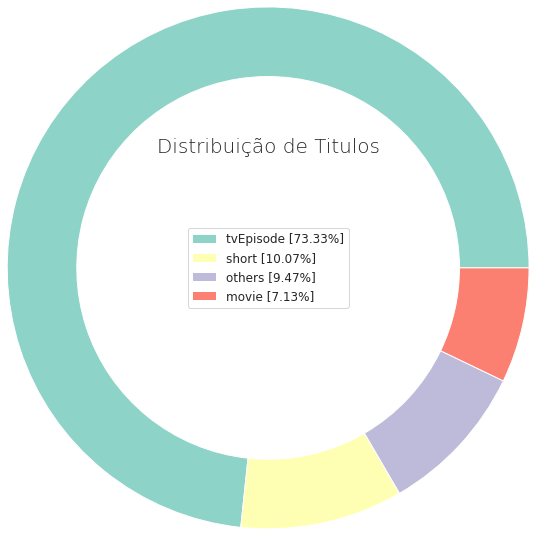

In [47]:
# Plot 

# Mapa de Cores
# https://matplotlib.org/stable/tutorials/colors/colormaps.html
cs = cm.Set3(np.arange(100))

# Cria a figura
f = plt.figure()

# Pie Plot
plt.pie(resultado1['COUNT'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size':12})
plt.title("Distribuição de Titulos", loc = 'Center', fontdict = {'fontsize': 20, 'fontweight': 20})
plt.show()

# 2- Qual o Número de Títulos Por Gênero?

Vamos calcular o número defilmes por gênero e entregar o resultado em valor percentual.

In [48]:
# Cria a consulta SQL
consulta2 = '''SELECT  genres, COUNT(*) FROM  titles  WHERE type = 'movie' GROUP BY genres'''

In [49]:
# Resultado
resultado2 = pd.read_sql_query(consulta2, conn)

In [50]:
# Visualiza o resultado
display(resultado2)

,genres,COUNT(*)
0,Action,13387
1,"Action,Adult",11
2,"Action,Adult,Adventure",1
3,"Action,Adult,Comedy",5
4,"Action,Adult,Crime",10
...,...,...
1442,"Thriller,Western",39
1443,War,1254
1444,"War,Western",9
1445,Western,4012


In [51]:
# Converte as Strings para minúsculo
resultado2['genres'] = resultado2['genres'].str.lower().values

In [52]:
# Remove Valores NA (ausentes)
temp = resultado2['genres'].dropna()

Usamos o Countvectorizer para converter a coluna de gêneros em um vetor one-hot encoded para contar o número de filmes em cada gênero - matriz esparsa - para dados em string

In [57]:
# Vamos cirum vetor usando expressão regular para filtrar as strings
# https://docs.python.org/3/library/re.html
padrao = '(?u)\\b[\\w-]+\\b'

# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#Convert a collection of text documents to a matrix of token counts - matriz esparsa
vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [58]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [59]:
# Aplica a vetorização ao dataset sem valores NA
bag_generos = vetor.transform(temp)

In [60]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [61]:
# Mini Projeto 1 - Respondendo a Pergunta de Negócios2 parte b - tempo 03.38